In [1]:
import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from vcs2425 import ApplyColormap, train, evaluate, evaluate_topk, plot_training_curves, load_dataset_splits
import time

# 1. Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# 2. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
COLOR_MAP = 'stacked'

# 3. Transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((224, 224)),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
# 4. Load full dataset
train_dataset, val_dataset = load_dataset_splits('../../ILSVRC2012_depth', train_transform, val_transform)

BATCH_SIZE = 256

# 7. DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)

# Training


We are going to train only the classifier

In [4]:
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

for param in model.features.parameters():
    param.requires_grad = False
    
for param in model.classifier.parameters():
    param.requires_grad = True

model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
# Print the number of trainable and frozen parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

Total parameters: 61,100,840
Trainable parameters: 58,631,144
Frozen parameters: 2,469,696


# Fine Tuning Classifier


In [6]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-4
REDUCE_LR_PATIENCE = 3
REDUCE_LR_FACTOR = 0.5

# 9. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam([
    {'params': model.classifier.parameters(), 'lr': LEARNING_RATE }
], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=REDUCE_LR_FACTOR, patience=REDUCE_LR_PATIENCE)

In [7]:
NUM_EPOCHS = 30
MODEL_NAME = 'alexnet_pft'

train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []


for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_accuracy = train(model, 
        loader=train_loader, 
        criterion=criterion, 
        optimizer=optimizer,
        device=device,
        model_name=MODEL_NAME)

    train_time = time.time()

    eval_loss, eval_accuracy = evaluate(model, 
                                        loader=val_loader, 
                                        device=device,
                                        criterion=criterion)
    
    scheduler.step(eval_loss)
    
    eval_time = time.time()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} Time: {(eval_time-start_time):.2f}s - \n"
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Took {(train_time-start_time):.2f}s, \n"
          f"Val Loss: {eval_loss:.4f}, Val Accuracy: {eval_accuracy:.4f}, Took {(eval_time-train_time):.2f}s \n")

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_accuracy)

print("Training Complete!")

Epoch 1/30 Time: 37.76s - 
Train Loss: 5.7780, Train Accuracy: 0.0520, Took 31.15s, 
Val Loss: 4.9803, Val Accuracy: 0.1028, Took 6.60s 



Epoch 2/30 Time: 32.91s - 
Train Loss: 5.0462, Train Accuracy: 0.0961, Took 26.54s, 
Val Loss: 4.7221, Val Accuracy: 0.1320, Took 6.37s 



Epoch 3/30 Time: 32.93s - 
Train Loss: 4.7555, Train Accuracy: 0.1184, Took 26.47s, 
Val Loss: 4.6134, Val Accuracy: 0.1420, Took 6.46s 



Epoch 4/30 Time: 33.27s - 
Train Loss: 4.5323, Train Accuracy: 0.1423, Took 26.88s, 
Val Loss: 4.5302, Val Accuracy: 0.1557, Took 6.39s 



Epoch 5/30 Time: 33.14s - 
Train Loss: 4.3630, Train Accuracy: 0.1613, Took 26.76s, 
Val Loss: 4.4862, Val Accuracy: 0.1581, Took 6.38s 



Epoch 6/30 Time: 32.32s - 
Train Loss: 4.1850, Train Accuracy: 0.1837, Took 25.96s, 
Val Loss: 4.4637, Val Accuracy: 0.1655, Took 6.37s 



Epoch 7/30 Time: 33.49s - 
Train Loss: 4.0912, Train Accuracy: 0.1932, Took 27.09s, 
Val Loss: 4.4494, Val Accuracy: 0.1700, Took 6.40s 



Epoch 8/30 Time: 32.45s - 
Train Loss: 3.9996, Train Accuracy: 0.2045, Took 26.02s, 
Val Loss: 4.4478, Val Accuracy: 0.1706, Took 6.43s 



Epoch 9/30 Time: 33.14s - 
Train Loss: 3.9501, Train Accuracy: 0.2114, Took 26.83s, 
Val Loss: 4.4290, Val Accuracy: 0.1758, Took 6.31s 



Epoch 10/30 Time: 32.78s - 
Train Loss: 3.8492, Train Accuracy: 0.2224, Took 26.38s, 
Val Loss: 4.4228, Val Accuracy: 0.1779, Took 6.40s 



Epoch 11/30 Time: 32.84s - 
Train Loss: 3.8179, Train Accuracy: 0.2312, Took 26.35s, 
Val Loss: 4.4218, Val Accuracy: 0.1790, Took 6.49s 



Epoch 12/30 Time: 32.62s - 
Train Loss: 3.7886, Train Accuracy: 0.2341, Took 26.22s, 
Val Loss: 4.4200, Val Accuracy: 0.1781, Took 6.40s 



Epoch 13/30 Time: 32.44s - 
Train Loss: 3.7527, Train Accuracy: 0.2373, Took 26.02s, 
Val Loss: 4.4237, Val Accuracy: 0.1808, Took 6.42s 



Epoch 14/30 Time: 33.43s - 
Train Loss: 3.6999, Train Accuracy: 0.2447, Took 27.06s, 
Val Loss: 4.4278, Val Accuracy: 0.1810, Took 6.36s 



Epoch 15/30 Time: 33.00s - 
Train Loss: 3.6821, Train Accuracy: 0.2460, Took 26.57s, 
Val Loss: 4.4284, Val Accuracy: 0.1811, Took 6.43s 



Epoch 16/30 Time: 33.23s - 
Train Loss: 3.6743, Train Accuracy: 0.2479, Took 26.36s, 
Val Loss: 4.4268, Val Accuracy: 0.1815, Took 6.87s 



Epoch 17/30 Time: 32.58s - 
Train Loss: 3.6443, Train Accuracy: 0.2505, Took 26.22s, 
Val Loss: 4.4297, Val Accuracy: 0.1826, Took 6.36s 



Epoch 18/30 Time: 33.21s - 
Train Loss: 3.6224, Train Accuracy: 0.2539, Took 26.86s, 
Val Loss: 4.4293, Val Accuracy: 0.1826, Took 6.35s 



Epoch 19/30 Time: 33.65s - 
Train Loss: 3.6201, Train Accuracy: 0.2562, Took 26.79s, 
Val Loss: 4.4306, Val Accuracy: 0.1825, Took 6.86s 



Epoch 20/30 Time: 33.86s - 
Train Loss: 3.6108, Train Accuracy: 0.2566, Took 27.23s, 
Val Loss: 4.4298, Val Accuracy: 0.1829, Took 6.64s 



Epoch 21/30 Time: 32.75s - 
Train Loss: 3.6118, Train Accuracy: 0.2564, Took 26.29s, 
Val Loss: 4.4307, Val Accuracy: 0.1824, Took 6.46s 



Epoch 22/30 Time: 34.14s - 
Train Loss: 3.5813, Train Accuracy: 0.2611, Took 27.45s, 
Val Loss: 4.4311, Val Accuracy: 0.1835, Took 6.69s 



Epoch 23/30 Time: 33.06s - 
Train Loss: 3.5831, Train Accuracy: 0.2604, Took 26.46s, 
Val Loss: 4.4318, Val Accuracy: 0.1833, Took 6.60s 



Epoch 24/30 Time: 33.83s - 
Train Loss: 3.5771, Train Accuracy: 0.2620, Took 27.01s, 
Val Loss: 4.4313, Val Accuracy: 0.1839, Took 6.82s 



Epoch 25/30 Time: 32.96s - 
Train Loss: 3.5828, Train Accuracy: 0.2602, Took 26.54s, 
Val Loss: 4.4313, Val Accuracy: 0.1839, Took 6.41s 



Epoch 26/30 Time: 33.04s - 
Train Loss: 3.5775, Train Accuracy: 0.2598, Took 26.51s, 
Val Loss: 4.4314, Val Accuracy: 0.1836, Took 6.52s 



Epoch 27/30 Time: 33.69s - 
Train Loss: 3.5740, Train Accuracy: 0.2646, Took 27.31s, 
Val Loss: 4.4318, Val Accuracy: 0.1841, Took 6.38s 



Epoch 28/30 Time: 34.55s - 
Train Loss: 3.5597, Train Accuracy: 0.2635, Took 27.83s, 
Val Loss: 4.4322, Val Accuracy: 0.1842, Took 6.72s 



Epoch 29/30 Time: 33.18s - 
Train Loss: 3.5695, Train Accuracy: 0.2633, Took 26.86s, 
Val Loss: 4.4328, Val Accuracy: 0.1842, Took 6.32s 



Epoch 30/30 Time: 33.26s - 
Train Loss: 3.5664, Train Accuracy: 0.2633, Took 26.70s, 
Val Loss: 4.4327, Val Accuracy: 0.1841, Took 6.56s 

Training Complete!


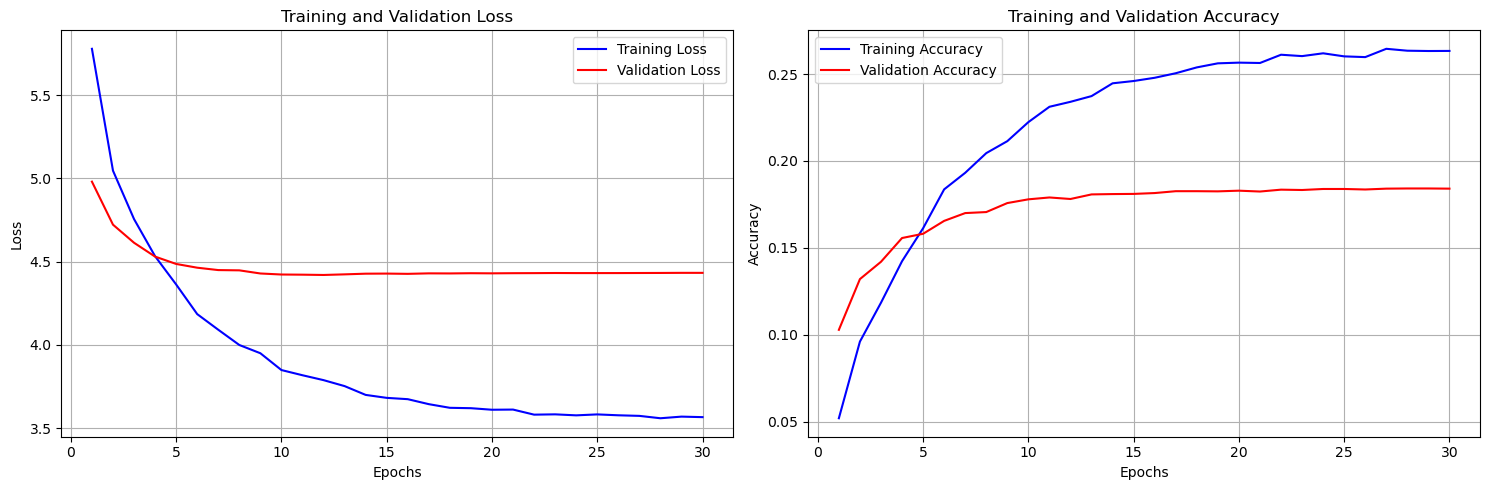

In [8]:
plot_training_curves(
    (train_losses, train_accuracies),
    (eval_losses, eval_accuracies),
)

# Evaluation metrics

In [9]:
# Load the best model weights
best_model_path = f"{MODEL_NAME}.pth"

# Load the saved model weights
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set the model to evaluation mode
print(f"Loaded best model from {best_model_path}")

# Evaluate the loaded model
val_loss, val_accuracy = evaluate(model, val_loader, criterion, device=device)
print(f"Best model - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Loaded best model from alexnet_pft.pth


Best model - Validation Loss: 4.4327, Validation Accuracy: 0.1836


In [10]:
top_1 = evaluate_topk(model, val_loader, k=1, device=device)
top_5 = evaluate_topk(model, val_loader, k=5, device=device)

print(f"Colormap: {COLOR_MAP}, Top-1 Accuracy: {top_1:.4f}, Top-5 Accuracy: {top_5:.4f}")

Colormap: stacked, Top-1 Accuracy: 0.1805, Top-5 Accuracy: 0.3641
